# What is the James-Stein shrinkage estimator?

The James-Stein estimator is a surprising result in the field of nonparametric statistics. To best understand its use case, this notebook simulates the classic example which James and Stein used in their original [paper](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwjuror3jdDqAhVGG80KHbFED8YQFjAFegQIAhAB&url=http%3A%2F%2Fwww.stat.cmu.edu%2F~larry%2F%3Dsml%2Fstein.pdf&usg=AOvVaw08vzo_qBgaUTlHO4Ewbzaj): baseball batting averages.

Consider we have data on 15 baseball players' batting averages throughout their first 45 at-bats at the end of the season. We wish to estimate their "true ability" (or alternatively: their batting average at the end of the season), in such a way that our *total squared error* is minimized across all 15 estimates.

Let $p_i$ denote the true probability player $i$ gets a hit in any recorded at-bat (each at-bat is a Bernoulli event).  A natural estimator $\widehat{p_i}$ to consider in this case is to calculate, for each player $i$,
$$ \widehat{p_i} = \frac{\text{# of hits}}{\text{# of recorded at bats}} $$
(In this example, the # of at bats is 45).

Indeed, if we were only estimating one player's batting average, this would be the best way to do so. It is the maximum likelihood estimator (MLE), the minimum variance unbiased estimator (MVUE), and the Bayes estimator under a flat prior (Wasserman: *All of Nonparametric Statistics*, pp. 146-147). However, in this scenario, where we wish to minimize our total risk across *all 15* estimates, **it is a poor estimator**.

James and Stein arrived at the surprising conclusion that we can do much better than simply calculating the MLE for each player, by "shrinking" each estimate towards the grand "average of averages" by an optimal amount. In this notebook, we will simulate at-bats for many different players, and empirically observe the decrease in risk afforded by the James-Stein estimator.

As a final note, with all this talk of parameters, it may be confusing as to why this estimator is classified under *nonparametric* statistics. Simply put, it is because the number of parameters is growing at the same rate as the number of data points (i.e., players).

In [49]:
# imports
import random
import names
import numpy as np
import pandas as pd
import pylab as pl
import matplotlib.pyplot as plt
import random
from matplotlib import collections as mc

These classes will contain information on all of our players.

In [50]:
# class definitions
class BallPlayer:
    def __init__(self):
        '''
        :name: name of the player
        :true_ability: the player's "true" batting percentage (from the data-
        generating Bernoulli model)
        :at_bats: record of the player's at bats
        :obs_avg: MLE of batting percentage
        '''
        self.name = names.get_full_name()
        self.true_ability = random.uniform(0.2, 0.4)
        self.at_bats = []
        self.obs_avg = 0


class BaseballTeam:
    def __init__(self, num_players=15):
        '''
        Initialize a BallPlayers for num_players (default: 15).
        '''
        self.players = [BallPlayer() for i in range(num_players)]
        self.num_players = num_players
        self.total_at_bats = 0

    def add_at_bats(self, num_at_bats):
        '''
        Generate num_at_bats worth of data for each player, according to the
        data-generating Bernoulli model. Update their observed average.
        '''
        self.total_at_bats += num_at_bats
        for player in self.players:
            pop = [0, 1]
            wts = [1 - player.true_ability, player.true_ability]
            player.at_bats += random.choices(pop, wts, k=num_at_bats)
            player.obs_avg = sum(player.at_bats) / self.total_at_bats

    def reset_at_bats(self):
        '''
        Return the baseball data to the initial state
        '''
        self.total_at_bats = 0
        for player in self.players:
            player.at_bats = []
            player.obs_avg = 0
            
    def yield_names(self):
        '''
        return the names of all players in a list
        '''
        return [p.name for p in self.players]
    
    def yield_true_abilities(self):
        '''
        return the true abilities of all players in a list
        '''
        return [p.true_ability for p in self.players]

    def averages_after_k_at_bats(self, k):
        '''
        Calculate the observed average for each player after k at bats,
        and return as a list
        '''
        return [sum(p.at_bats[:k]) / k for p in self.players]

    def end_of_season_averages(self):
        '''
        Calculate the batting average for each player at the end of the
        simulated season and return as a list
        '''
        return [sum(p.at_bats) / self.total_at_bats for p in self.players]

The James-Stein estimator applies in the context "Many Normal Means". Since our data our Bernoulli, we use an $\arcsin$ variance-stabilizing transform to make each MLE normally distributed with variance $1$. We then apply the generalized James-Stein formula, and finally use the reverse transform to recover estimates of each players' batting average.

In [51]:
# functions
def norm(vector):
    '''
    Calculate the L2 norm of a vector
    '''
    return sum([v ** 2 for v in vector]) ** 0.5


def arcsin_transform(obs_avgs, num_at_bats):
    '''
    Perform an arcsin variance-stabilizing transform to make the observed
    proportions from the Bernoulli model Normally distributed with variance 1.
    '''
    return [(num_at_bats ** 0.5) * np.arcsin(2 * avg - 1) for avg in obs_avgs]


def reverse_arcsin_transform(transformed_avgs, num_at_bats):
    '''
    Reverse the arcsin transform to recover the original proportion
    '''
    return [(np.sin(z / (num_at_bats ** 0.5)) + 1) * 0.5 for z in transformed_avgs]


def generalized_js(batting_averages, num_at_bats, variance=1):
    '''
    Produces James-Stein estimates of the players's batting averages after
    num_at_bats
    '''
    transformed_avgs = arcsin_transform(batting_averages, num_at_bats)
    m = len(transformed_avgs)
    v = np.mean(transformed_avgs)
    zs = [z - v for z in transformed_avgs]
    at = [v + (1 - (m - 3) * variance / (norm(zs) ** 2)) * z for z in zs]
    return reverse_arcsin_transform(at, num_at_bats)


def calculate_total_risk(estimates, parameters):
    '''
    Calculate the total risk across a list of estimates and their parameters,
    according to the squared error loss function
    '''
    return sum([(e - p) ** 2 for e, p in zip(estimates, parameters)])


def calculate_risks_after_each_at_bat(team):
    '''
    Calculate the total risk for each estimate (MLE and GJS) after each at bat,
    and return as a pandas DataFrame
    '''
    mle_risks = [float('inf') for i in range(team.total_at_bats)]
    gjs_risks = [float('inf') for i in range(team.total_at_bats)]
    for num in range(20, team.total_at_bats + 1):
        tmp_mle = team.averages_after_k_at_bats(num)
        tmp_gjs = generalized_js(tmp_mle, num)
        mle_risks[num - 1] = calculate_total_risk(tmp_mle, team.yield_true_abilities())
        gjs_risks[num - 1] = calculate_total_risk(tmp_gjs, team.yield_true_abilities())
    
    return pd.DataFrame(data = {
        'num_at_bats': list(range(team.total_at_bats)),
        'mle_risks': mle_risks,
        'gjs_risks': gjs_risks,
        'risk_diffs': [m - g for m, g in zip(mle_risks, gjs_risks)]
    })


def plot_risks_after_each_at_bat(team):
    '''
    Plot the total squared error loss of the Generalized James-Stein estimates
    and the MLE estimates against number of at bats
    '''
    df = calculate_risks_after_each_at_bat(team)
    plt.figure()
    risks_plot = df.plot(
        x='num_at_bats',
        y=['mle_risks', 'gjs_risks'],
        figsize=(15, 7.5),
        title='Total squared error loss of Generalized James-Stein estimator and MLE estimator, by number of at-bats'
    )
    plt.xlabel('Number of at-bats')
    plt.ylabel('Total Squared Error Loss')
    plt.show()
    return None


def create_estimate_df(team, k):
    '''
    create a pandas DataFrame with the MLE and Generalized James-Stein estimates
    for each player after k at bats
    '''
    # calculate MLE estimate of batting averages after estimate_from_k at bats
    mle_estimates_after_k = team.averages_after_k_at_bats(k)

    # calculate generalized James-Stein estimates of batting averages after estimate_from_k at bats
    gjs_estimates_after_k = generalized_js(mle_estimates_after_k, k)

    # names of each player
    team_names = team.yield_names()

    # 'true ability' (bernoulli parameter) for each player
    team_true_abilities = team.yield_true_abilities()
    
    # create a pandas DataFrame to store this data
    df = pd.DataFrame(data = {
        'Name': team_names,
        'MLE_est': mle_estimates_after_k,
        'GJS_est': gjs_estimates_after_k,
        'True_ability': team_true_abilities
    })
    
    return df


def plot_shrinkage(team, k):
    '''
    Visually show the effect of a shrinkage estimator
    '''
    df = create_estimate_df(team, k)
    mle = list(df['MLE_est'])
    gjs = list(df['GJS_est'])
    names = list(df['Name'])
    lines = []
    colors = []
    array = []
    for m, g, n in zip(mle, gjs, names):
        array.append([m, 2, g, 1])
        
    # plot the effect of shrinkage
    plt.figure(figsize=(15,7.5))
    array = np.array(array)    
    center_text = 0.5 * (min(mle) + max(mle))  
    plt.plot(array[:,::2].T, array[:, 1::2].T)
    plt.text(
        x=center_text,
        y=2.15,
        s='MLE Estimates',
        horizontalalignment='center',
        verticalalignment='center'
    )
    plt.text(
        x=center_text,
        y=0.75,
        s='Generalized James-Stein Estimates',
        horizontalalignment='center',
        verticalalignment='center'
    )
    plt.legend(labels=names, loc='best')
    plt.show()


def user_run_simulation():
    '''
    Allow the user to simulate data from a team, and print out the effects
    of estimating true ability after a certain number of at bats, according
    to the user's specifications
    '''
    # ask the user how many players to generate data for
    number_of_players = int(input('How many players should we generate data for? (suggested: 15)\n'))
    baseball_team = BaseballTeam(number_of_players)
    
    # ask the user the total number of at-bats to generate data for
    total_at_bats = int(input('How many at-bats should be simulated for each player? (suggested: 500)\n'))
    
    # ask the user to give the number of at-bats to estimate from
    estimate_from_k = int(input('How many at-bats should we estimate the true parameters from? (suggested: 50)\n'))
    
    if estimate_from_k > total_at_bats:
        print('You can\'t estimate from more at bats than we have data for! Exiting...')
        
    # add total_at_bats worth of data to the team
    baseball_team.add_at_bats(total_at_bats)
    
    # create a DataFrame to hold estimates
    baseball_df = create_estimate_df(baseball_team, estimate_from_k)
    mle_estimates = list(baseball_df['MLE_est'])
    gjs_estimates = list(baseball_df['GJS_est'])
    true_abilities = list(baseball_df['True_ability'])

    # total risk from MLE estimate after k at bats
    mle_risk = calculate_total_risk(mle_estimates, true_abilities)

    # total risk from GJS estiamte after k at bats
    gjs_risk = calculate_total_risk(gjs_estimates, true_abilities)

    # print relevant statistics
    print(f'\nData after {estimate_from_k} at bats')
    print(baseball_df)
    print(f'\nMLE squared error loss: {mle_risk}')
    print(f'Generalized James-Stein squared error loss: {gjs_risk}')
    
    return baseball_team, estimate_from_k

Now, here's the simulation. You can choose the number of players, the number of at-bats to simulate, and the number of at-bats to estimate the true parameters from (the prompt will offer suggested values). The code will do the rest. A table of the "observed" batting averages (MLE estimates), the generalized James-Stein estimate, and the true parameter for each player will then be displayed.

In [52]:
# run the simulation, ask the user for input
baseball_team, estimate_from_k = user_run_simulation()

How many players should we generate data for? (suggested: 15)
15
How many at-bats should be simulated for each player? (suggested: 500)
500
How many at-bats should we estimate the true parameters from? (suggested: 50)
50

Data after 50 at bats
               Name  MLE_est   GJS_est  True_ability
0       Paul Tucker     0.36  0.340740      0.278751
1    Nicole Hickman     0.32  0.320609      0.331576
2      Fred Griffin     0.22  0.268441      0.261161
3       Larry Brill     0.20  0.257488      0.214784
4     Jimmie Tobias     0.24  0.279178      0.279011
5      Linda Howard     0.42  0.370587      0.380523
6      Jason Ruelas     0.26  0.289736      0.204550
7    Ronald Saucier     0.28  0.300144      0.270358
8   Alicia Matthews     0.46  0.390411      0.324958
9   Patricia Hughes     0.32  0.320609      0.249309
10   William Amador     0.32  0.320609      0.282424
11    William Weber     0.24  0.279178      0.258450
12  Shirley Johnson     0.34  0.330708      0.335539
13    Teresa W

To put this "shrinkage" towards the average-of-averages into visual context, the plot below will display the change between the MLE estimates (top) and their "shrunken" counterparts (bottom).

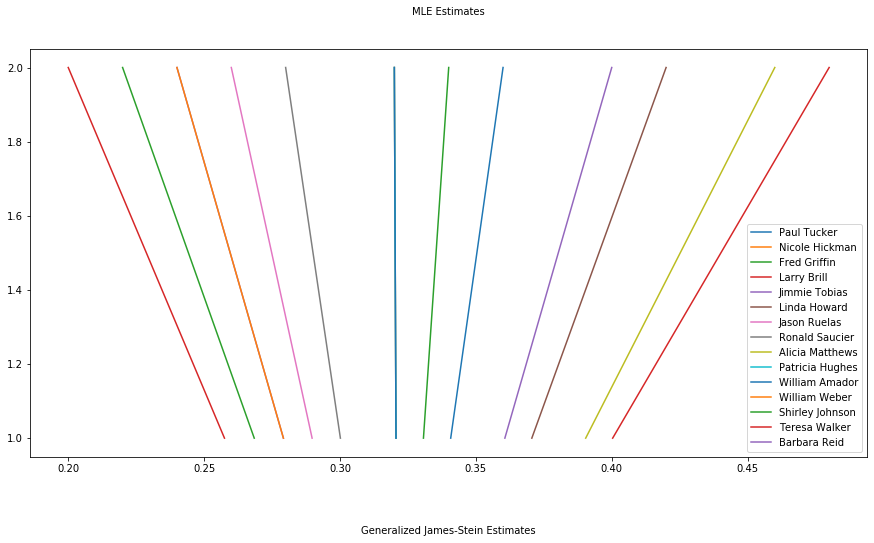

In [53]:
# plot the effect of the shrinkage estimate
plot_shrinkage(baseball_team, estimate_from_k)

Finally, this plot will show the (empirically observed) total squared-error loss between MLE estimates and James-Stein estimates of the players' batting averages as the number of at-bats observed increases. The generalized James-Stein estimator should dominate the MLE estimate by a large amount when the number of at-bats is small; this difference will decrease as the number of at-bats increases, but (in theory) the James-Stein estimator nonetheless dominates the MLE estimates in all cases.

<Figure size 432x288 with 0 Axes>

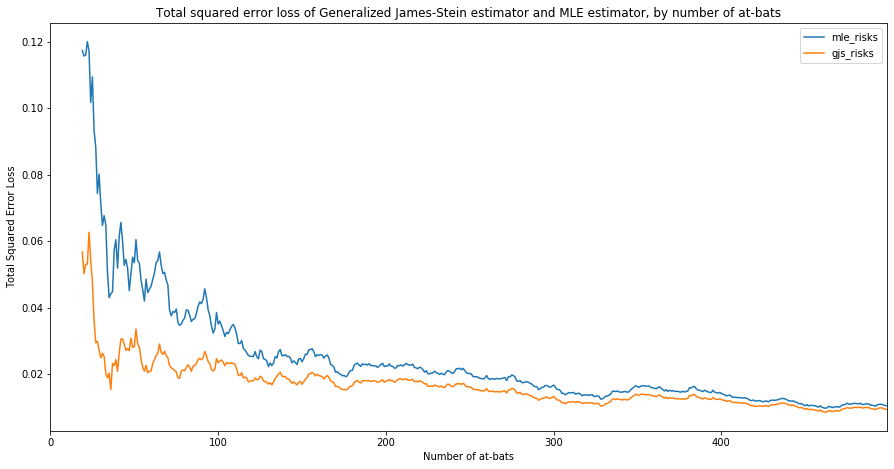

In [54]:
# plot the change in total squared error loss for each type of estimate
plot_risks_after_each_at_bat(baseball_team)

Feel free to play around with the `baseball_team` object in the below code-block to examine its contents in greater detail.